# MMDet Inference for Norway

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import asyncio
import glob
from argparse import ArgumentParser
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

from mmcv import Config
from mmdet.apis import async_inference_detector, inference_detector, show_result_pyplot
from mmdet.apis.inference import init_detector

from ensemble_boxes import *
from mmdet.core.bbox.iou_calculators import bbox_overlaps
import pandas as pd


In [2]:
def get_json_data(label_path):
    with open(label_path, encoding='utf-8-sig') as f:
        json_data = json.load(f)
    return json_data

In [3]:
def convert_wbf(results, image_size, threshold = 0.4):
    boxes_list = []
    scores_list = []
    labels_list = []
    for predicted_class in range(len(results)):
        for preds in results[predicted_class]:
            if preds[-1] >= threshold:
                # print(preds)
                box = preds[:4]
                if image_size:
                    boxes_list.append([box[0]/image_size[1],
                                       box[1]/image_size[0],
                                       box[2]/image_size[1],
                                       box[3]/image_size[0]]
                                       )
                if image_size == False:
                    boxes_list.append([box[0],
                                       box[1],
                                       box[2],
                                       box[3]]
                                       )
                score = preds[-1].astype(float)
                scores_list.append(score)
                labels_list.append(predicted_class+1)
    return boxes_list, labels_list, scores_list

In [4]:
def get_iou(pred_box, gt_box):
    # 1.get the coordinate of inters
    ixmin = max(pred_box[0], gt_box[0])
    ixmax = min(pred_box[2], gt_box[2])
    iymin = max(pred_box[1], gt_box[1])
    iymax = min(pred_box[3], gt_box[3])
    iw = np.maximum(ixmax-ixmin+1., 0.)
    ih = np.maximum(iymax-iymin+1., 0.)
    # 2. calculate the area of inters
    inters = iw*ih
    # 3. calculate the area of union
    uni = ((pred_box[2]-pred_box[0]+1.) * (pred_box[3]-pred_box[1]+1.) +
           (gt_box[2] - gt_box[0] + 1.) * (gt_box[3] - gt_box[1] + 1.) -
           inters)
    # 4. calculate the overlaps between pred_box and gt_box
    iou = inters / uni
    return iou

In [5]:
fs_config_files =  ['/media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/india_vfnet_resnet101_train_all_aug/india_vfnet_train_all_augment.py',
                   '/media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/vfnet_1500x900_train_norway/norway_vfnext_train_norway_augment.py']
    
fs_checkpoints = ['/media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/india_vfnet_resnet101_train_all_aug/epoch_10.pth',
                 '/media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/vfnet_1500x900_train_norway/epoch_73.pth']

In [6]:
def load_model(config, checkpoint):
    model = init_detector(config, checkpoint, device='cuda:0')
    model.CLASSES = ['D00','D10','D20','D40']
    return model

## Load models

In [7]:
model_1 = load_model(fs_config_files[0], fs_checkpoints[0])
model_2 = load_model(fs_config_files[1], fs_checkpoints[1])
# model_3 = load_model(fs_config_files[2], fs_checkpoints[2])
# model_4 = load_model(fs_config_files[3], fs_checkpoints[3])

load checkpoint from local path: /media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/india_vfnet_resnet101_train_all_aug/epoch_10.pth


2022-10-05 14:42:35,451 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-10-05 14:42:35,454 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-10-05 14:42:35,457 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-10-05 14:42:35,463 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-10-05 14:42:35,466 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-10-05 14:42:35,469 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-10-05 14:42:35,472 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-10-05 14:42:35,476 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-10-05 14:42:35,479 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

load checkpoint from local path: /media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/trained_weights/vfnet_1500x900_train_norway/epoch_73.pth


2022-10-05 14:42:40,435 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-10-05 14:42:40,439 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-10-05 14:42:40,442 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-10-05 14:42:40,445 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-10-05 14:42:40,448 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-10-05 14:42:40,452 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-10-05 14:42:40,455 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-10-05 14:42:40,460 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-10-05 14:42:40,463 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

## Visualize

In [8]:
COUNTRY_NAMES = ['Norway', 'Czech', 'Japan',
               'Norway', 'United_States',
               'China_MotorBike']

In [9]:
class_dict_raw = {1:'D00',
            2:'D10',
            3:'D20',
            4:'D40'}
color_dict = {1:(255, 0, 0),
            2:(255, 128, 0),
            3:(255, 255, 0),
            4:(128, 255, 0)}

In [10]:
# WBF config
weights = [1,1]
iou_thr = 0.5
skip_box_thr = 0.001
sigma = 0.1
pred_threshold_1 = 0.4
pred_threshold_2 = 0.7
# pred_threshold_3 = 0.4
# pred_threshold_4 = 0.4

In [11]:
def visualize_pred_bboxes(pred_boxes, pred_labels, image):
    for pred_label_num, pred_box in enumerate(pred_boxes):
        # print(pred_box)
        start_point = (int(pred_box[0]), int(pred_box[1]))
        end_point =   (int(pred_box[2]), int(pred_box[3]))
        class_id = pred_labels[pred_label_num]
        image = cv2.rectangle(image, start_point, end_point,  color_dict[class_id], 10)
        cv2.putText(image, class_dict_raw[class_id], start_point, 
                cv2.FONT_HERSHEY_SIMPLEX, 2, color_dict[class_id], 3, cv2.LINE_AA)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

=============== Norway


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Norway_004260.jpg


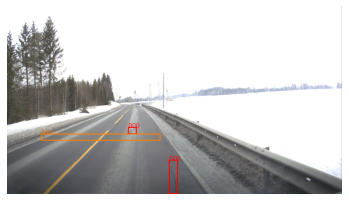

/media/daitran/Data_SSD1/IEEE/github/CRDDC_2022_Code/mmdet_based/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/home/daitran/miniconda3/envs/mmdetection/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VFNet Train All


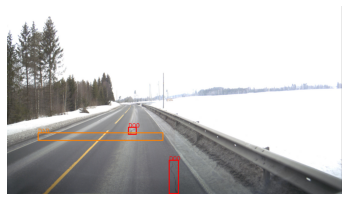

VFNet Train on Norway


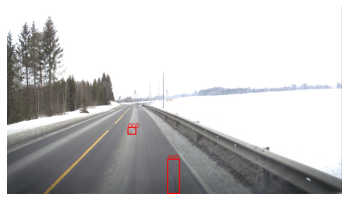

Ensemble


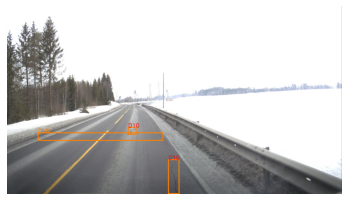

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]

Number of correct bboxes = 3 - Incorrect bboxes = 0 - Number of total GT = 3


In [12]:
for country in COUNTRY_NAMES:
    gt_totals =[]
    correct_predictions = []
    print("=============== {}".format(country))
    IMAGE_DIR = "/media/daitran/Data_SSD1/IEEE/data/{}/train/images".format(country)
    json_path = '/media/daitran/Data_SSD1/IEEE/src/prepare_data/train_labels/{}/train/annotations/coco/test_balance.json'.format(country)
    json_data =get_json_data(json_path)
    for image_info in tqdm(json_data['images'][:1]):
        image_id = image_info['id']
        image_path = os.path.join(IMAGE_DIR, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image_info['file_name'])
        # # Load GT boxes and labels
        gt_boxes = []
        gt_labels = []
        for annotation in json_data['annotations']:
            if image_id == annotation['image_id']:
                # print(annotation)
                bbox = annotation['bbox']
                start_point = (int(bbox[0]), int(bbox[1]))
                end_point =   (int(bbox[2]+bbox[0]), int(bbox[3]+bbox[1]))
                class_id = annotation['category_id']
                image = cv2.rectangle(image, start_point, end_point,  color_dict[class_id], 10)
                cv2.putText(image, class_dict_raw[class_id], start_point, 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, color_dict[class_id], 3, cv2.LINE_AA)
                # # add
                gt_boxes.append(bbox)
                gt_labels.append(class_id)
                gt_totals.append(class_id)
        plt.axis('off')
        plt.imshow(image)
        plt.show()
        # Prediction
        image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_size = image.shape
        result_1 = inference_detector(model_1, image)
        result_2 = inference_detector(model_2, image)
        # result_3 = inference_detector(model_3, image)
        # result_4 = inference_detector(model_4, image)
        
        # VISUALIZE
        boxes_list1, labels_list1, scores_list1 = convert_wbf(result_1,
                                                              image_size = False, threshold =pred_threshold_1)
        boxes_list2, labels_list2, scores_list2 = convert_wbf(result_2, 
                                                              image_size = False, threshold = pred_threshold_2)
        # boxes_list3, labels_list3, scores_list3 = convert_wbf(result_3, 
                                                              # image_size = False, threshold = pred_threshold_3)
        # boxes_list4, labels_list4, scores_list4 = convert_wbf(result_4, 
        #                                                       image_size = False, threshold = pred_threshold_4)
        # Visualize seperate
        print("VFNet Train All")
        image_vis = cv2.imread(image_path)
        image_vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        visualize_pred_bboxes(boxes_list1, labels_list1, image_vis)
        print("VFNet Train on Norway")
        image_vis = cv2.imread(image_path)
        image_vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        visualize_pred_bboxes(boxes_list2, labels_list2, image_vis)
        
        # image_vis = cv2.imread(image_path)
        # image_vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # visualize_pred_bboxes(boxes_list3, labels_list3, image_vis)
        
        # image_vis = cv2.imread(image_path)
        # image_vis = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # visualize_pred_bboxes(boxes_list4, labels_list4, image_vis) 
        
        # ENSEMBLE
        boxes_list1, labels_list1, scores_list1 = convert_wbf(result_1, image_size, threshold =pred_threshold_1)
        boxes_list2, labels_list2, scores_list2 = convert_wbf(result_2, image_size, threshold = pred_threshold_2)
        # boxes_list3, labels_list3, scores_list3 = convert_wbf(result_3, image_size, threshold = pred_threshold_3)
        # boxes_list4, labels_list4, scores_list4 = convert_wbf(result_4, image_size, threshold = pred_threshold_4)
        
        
        boxes_list_merges = []
        labels_list_merges = []
        scores_list_merges = []
        boxes_list_merges.append(boxes_list1)
        boxes_list_merges.append(boxes_list2)
        # boxes_list_merges.append(boxes_list3)
        # boxes_list_merges.append(boxes_list4)
        
        labels_list_merges.append(labels_list1)
        labels_list_merges.append(labels_list2)
        # labels_list_merges.append(labels_list3)
        # labels_list_merges.append(labels_list4)
        
        scores_list_merges.append(scores_list1)
        scores_list_merges.append(scores_list2)
        # scores_list_merges.append(scores_list3)
        # scores_list_merges.append(scores_list4)
        
        # Weighted box fusion
        normalize_ensemble_boxes, ensemble_scores, normalize_ensemble_labels = weighted_boxes_fusion(boxes_list_merges, scores_list_merges, 
                                                      labels_list_merges, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        ensemble_boxes = []
        ensemble_labels = []
        print("Ensemble")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for i, predicted_box in enumerate(normalize_ensemble_boxes):
            unnormalize_box = [predicted_box[0]*image_size[1],
                             predicted_box[1]*image_size[0],
                             predicted_box[2]*image_size[1],
                             predicted_box[3]*image_size[0]]
            ensemble_boxes.append(unnormalize_box)
            ensemble_labels.append(int(normalize_ensemble_labels[i]))
            # visualize ensemble results
            start_point = (int(unnormalize_box[0]), int(unnormalize_box[1]))
            end_point =   (int(unnormalize_box[2]), int(unnormalize_box[3]))
            image = cv2.rectangle(image, start_point, end_point,  color_dict[class_id], 10)
            cv2.putText(image, class_dict_raw[class_id], start_point, 
                        cv2.FONT_HERSHEY_SIMPLEX, 2, color_dict[int(normalize_ensemble_labels[i])], 3, cv2.LINE_AA)
        plt.axis('off')
        plt.imshow(image)
        plt.show()
#         # Caculate IoU
        correct=0
        incorrect=0
        for pred_box_num, pred_label in enumerate(ensemble_labels):
            count = 0
            for gt_box_num, gt_label in enumerate(gt_labels):
                if pred_label == gt_label:
                    # print(iou)
                    temp_gt = [gt_boxes[gt_box_num][0],
                          gt_boxes[gt_box_num][1],
                          gt_boxes[gt_box_num][2] + gt_boxes[gt_box_num][0],
                          gt_boxes[gt_box_num][3] + gt_boxes[gt_box_num][1]]
                    iou = get_iou(ensemble_boxes[pred_box_num], temp_gt)
                    if iou >= 0.5:
                        count+=1
            if count>0:
                correct+=1
            else:
                incorrect+=1
        print("Number of correct bboxes = {} - Incorrect bboxes = {} - Number of total GT = {}".format
              (correct, incorrect, len(gt_labels)))
        # break
    break

## Submission

In [13]:
import natsort

In [14]:
def get_image_file_names(IMAGE_DIR):
    
    file_format = ['jpg']
    
    file_names = os.listdir(IMAGE_DIR)
    image_file_names = []
    for file_name in tqdm(file_names):
        if file_name.split('.')[-1] in file_format:
            image_file_names.append(file_name)
   
    return natsort.natsorted(image_file_names)

In [15]:
def inference2submission(country = 'Norway'):
    TEST_SET_DIR = '/media/daitran/Data_SSD1/IEEE/data/{}/test/images'.format(country)
    test_image_file_names  = get_image_file_names(TEST_SET_DIR)
    
    submission = pd.DataFrame(columns=['ImageId', 'PredictionString'])
    for test_num, test_image_file_name in tqdm(enumerate(test_image_file_names)):
        test_image_path = os.path.join(TEST_SET_DIR, test_image_file_name)

        image = cv2.imread(test_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_size = image.shape
        result_1 = inference_detector(model_1, image)
        result_2 = inference_detector(model_2, image)
        # result_3 = inference_detector(model_3, image)
        # result_4 = inference_detector(model_4, image)

        boxes_list1, labels_list1, scores_list1 = convert_wbf(result_1, image_size, threshold = pred_threshold_1)
        boxes_list2, labels_list2, scores_list2 = convert_wbf(result_2, image_size, threshold = pred_threshold_2)
        # boxes_list3, labels_list3, scores_list3 = convert_wbf(result_3, image_size, threshold = pred_threshold_3)
        # boxes_list4, labels_list4, scores_list4 = convert_wbf(result_4, image_size, threshold = pred_threshold_4)

        boxes_list_merges = []
        labels_list_merges = []
        scores_list_merges = []
        boxes_list_merges.append(boxes_list1)
        boxes_list_merges.append(boxes_list2)
        # boxes_list_merges.append(boxes_list3)
        # boxes_list_merges.append(boxes_list4)


        labels_list_merges.append(labels_list1)
        labels_list_merges.append(labels_list2)
        # labels_list_merges.append(labels_list3)
        # labels_list_merges.append(labels_list4)

        scores_list_merges.append(scores_list1)
        scores_list_merges.append(scores_list2)
        # scores_list_merges.append(scores_list3)
        # scores_list_merges.append(scores_list4)

        # Weighted box fusion
        normalize_ensemble_boxes, ensemble_scores, normalize_ensemble_labels = weighted_boxes_fusion(boxes_list_merges, scores_list_merges, 
                                                      labels_list_merges, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        ensemble_boxes = []
        ensemble_labels = []
        for i, predicted_box in enumerate(normalize_ensemble_boxes):
            unnormalize_box = [predicted_box[0]*image_size[1],
                             predicted_box[1]*image_size[0],
                             predicted_box[2]*image_size[1],
                             predicted_box[3]*image_size[0]]
            ensemble_boxes.append(unnormalize_box)
            ensemble_labels.append(int(normalize_ensemble_labels[i]))
        pred_str = ''
        for pred_num, pred_box in enumerate(ensemble_boxes):
            pred = '{} {} {} {} {} '.format(ensemble_labels[pred_num],
                                            int(pred_box[0]),
                                            int(pred_box[1]),
                                            int(pred_box[2]),
                                            int(pred_box[3]))
            pred_str = pred_str + pred
            # break
        # remove space
        final_pred_str = pred_str[:-1] 
        submission.loc[test_num,'ImageId'] = test_image_file_name
        submission.loc[test_num,'PredictionString'] = final_pred_str
    # Convert to txt
    data = submission
    save_lines = []
    for row_num in range(len(data)):
        row = data.iloc[row_num]
        if pd.isnull(row['PredictionString']):
            temp_txt = '{},'.format(row['ImageId'])
        else:
            temp_txt = '{},{}'.format(row['ImageId'], row['PredictionString'])
        save_lines.append(temp_txt)
    with open('./results/{}_ensemble_update.txt'.format(country), 'w') as f:
        for line in save_lines:
            f.write(line)
            f.write('\n')
    return submission

In [16]:
inference2submission(country = 'Norway')

100%|██████████████████████████████████| 2040/2040 [00:00<00:00, 1031261.92it/s]
235it [01:28,  2.78it/s]/home/daitran/miniconda3/envs/mmdetection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
374it [02:18,  2.82it/s]/home/daitran/miniconda3/envs/mmdetection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
2040it [12:38,  2.69it/s]


,ImageId,PredictionString
0,Norway_008161.jpg,1 1574 1471 1706 2033
1,Norway_008162.jpg,
2,Norway_008163.jpg,1 493 1614 622 1722 1 1451 1327 1546 1573 3 12...
3,Norway_008164.jpg,1 1602 1424 2163 2007 1 1321 1401 1452 1667 1 ...
4,Norway_008165.jpg,
...,...,...
2035,Norway_010196.jpg,2 389 1452 1823 1516
2036,Norway_010197.jpg,
2037,Norway_010198.jpg,
2038,Norway_010199.jpg,
